In [1]:
from tensorflow import keras
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
import numpy as np

In [6]:
batch_size = 100
original_dim = 784 # mnist height * width
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [7]:
def sampling(args: tuple):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
## Encoder
x = Input(shape=(original_dim), name='input')
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
z_mean = Dense(latent_dim, name='mean')(h)
z_log_var = Dense(latent_dim, name='log-varaince')(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name='encoder')

In [10]:
## Decoder
input_decoder = Input(shape=(latent_dim, ), name='decoder_input')
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name='flat_decoded')(decoder_h)
decoder = Model(input_decoder, x_decoded, name='decoder')

In [11]:
## 모델 결합
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [12]:
## loss function
kl_loss = -0.5 * K.sum(
    1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), 
    axis=-1)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [13]:
## train-test-split
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11490434/11490434 [==============================] - 0s 0us/step


In [14]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2445
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2195
Epoch 3/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2144
Epoch 4/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2097
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2067
Epoch 6/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2049
Epoch 7/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2035
Epoch 8/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2024
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2015
Epoch 10/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2006
Epoch 11/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1999
Epoch 12/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1992
Epoch 13/50
600/600 [====

100/100 [==============================] - 0s 808us/step


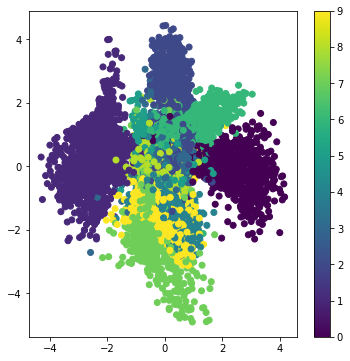

In [15]:
import matplotlib.pyplot as plt
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

In [20]:
from scipy.stats import norm

n = 15 # 15*15 number image
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [24]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

1/1 [==============================] - 0s 14ms/step


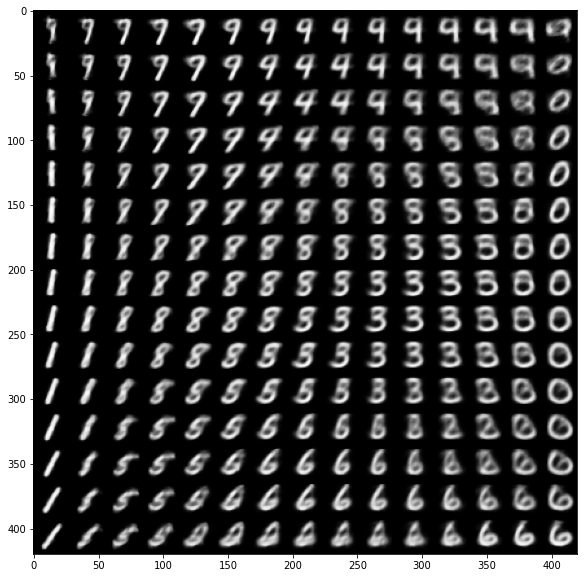

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()